# Classificazione di corpi celesti

**Programmazione di Applicazioni Data Intensive**

Laurea in Ingegneria e Scienze Informatiche

DISI - Università di Bologna, Cesena


**Studente**: Luca Marchi

**Matricola**: 0001070850


## 1. Analisi e descrizione del problema

### Scopo del progetto

Lo scopo di questo progetto è realizzare un modello che possa classificare i corpi celesti in base alle loro caratteristiche spettrali, utilizzando tecniche di machine learning per identificare le classi di oggetti celesti presenti nel dataset.

### Dataset

Si è preso come riferimento [questo](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17) dataset trovato sulla piattaforma [Kaggle](https://www.kaggle.com/). 

Il dataset contiene le caratteristiche spettrali dei corpi celesti.

Le caratteristiche spettrali sono linee o bande di assorbimento o emissione che compaiono nello spettro elettromagnetico (la "scomposizione" della luce). Sono come un codice a barre o un'impronta digitale unica che ci permette di decifrare la composizione chimica, la temperatura, la densità, la velocità e molte altre proprietà fisiche di stelle, galassie, pianeti e nebulose senza doverci recare fisicamente da loro.

I dati consistono in 100.000 osservazioni dello spazio raccolte dallo SDSS (Sloan Digital Sky Survey).
Ogni osservazione è descritta da 17 colonne di feature e 1 colonna di classe, che la identifica come stella, galassia o quasar.

### Librerie utilizzate

In [162]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### Caricamento dei dati 

In [163]:
FILE_NAME = "star_classification.csv"

In [164]:
# Download latest version
path = kagglehub.dataset_download("fedesoriano/stellar-classification-dataset-sdss17")

print("Path to dataset files:", path)


Path to dataset files: /Users/lucamarchi/.cache/kagglehub/datasets/fedesoriano/stellar-classification-dataset-sdss17/versions/1


In [165]:
df = pd.read_csv(f"{path}/{FILE_NAME}")

Osserviamo le prime righe del dataset per comprendere meglio la sua struttura e il tipo di informazioni contenute.

In [166]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


Otteniamo informazioni più dettagliate sull'uso della memoria, inclusi i tipi di dati e il numero di istanze non nulle.

In [167]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

Notiamo che nel dataset non sono presenti valori nulli, quindi possiamo procedere con le fasi successive senza doverci preoccupare di gestire dati mancanti.

### Significato delle colonne


Riporto di seguito il significato delle colonne del dataset come specificato dalla [fonte](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17):

- **obj_ID**: Identificatore dell’oggetto, il valore univoco che identifica l’oggetto nel catalogo di immagini usato dal CAS (Catalog Archive Server)

- **alpha**: Angolo di Ascensione Retta (all’epoca J2000)

- **delta**: Angolo di Declinazione (all’epoca J2000)

- **u**: Filtro ultravioletto nel sistema fotometrico

- **g**: Filtro verde nel sistema fotometrico

- **r**: Filtro rosso nel sistema fotometrico

- **i**: Filtro nel vicino infrarosso nel sistema fotometrico

- **z**: Filtro infrarosso nel sistema fotometrico

- **run_ID**: Numero di “run” usato per identificare la specifica scansione

- **rerun_ID**: Numero di “rerun” per specificare come è stata processata l’immagine

- **cam_col**: Colonna della camera che identifica la scanline all’interno del run

- **field_ID**: Numero di campo per identificare ciascun campo

- **spec_obj_ID**: ID univoco usato per oggetti spettroscopici ottici (questo significa che 2 osservazioni diverse con lo stesso spec_obj_ID devono condividere la stessa classe di output)

- **class**: Classe dell’oggetto (galassia, stella o quasar)

- **redshift**: Valore di redshift basato sull’aumento della lunghezza d’onda

- **plate**: ID della lastra, identifica ciascuna lastra nello SDSS

- **MJD**: Data Giuliana Modificata, usata per indicare quando è stato raccolto un determinato dato dello SDSS (sistema di datazione molto usato in astronomia per indicare momenti specifici nel tempo)

- **fiber_ID**: ID della fibra che identifica la fibra ottica che ha raccolto la luce nel piano focale in ciascuna osservazione

Rinominiamo in maniera più chiara le colonne del dataset per facilitare la comprensione e l'analisi dei dati.

In [168]:
df = df.rename(columns={
    "obj_ID": "object_id",
    "alpha": "right_ascension",
    "delta": "declination",
    "u": "ultraviolet_filter",
    "g": "green_filter",
    "r": "red_filter",
    "i": "near_infrared_filter",
    "z": "infrared_filter",
    "run_ID": "run_id",
    "rerun_ID": "rerun_id",
    "cam_col": "camera_column",
    "field_ID": "field_id",
    "spec_obj_ID": "spec_object_id",
    "MJD": "modified_julian_date",
    "fiber_ID": "fiber_id"
})

In [169]:
df.head()

,object_id,right_ascension,declination,ultraviolet_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,run_id,rerun_id,camera_column,field_id,spec_object_id,class,redshift,plate,modified_julian_date,fiber_id
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


### Visualizzazione della distribuzione delle classi

**Istogramma**

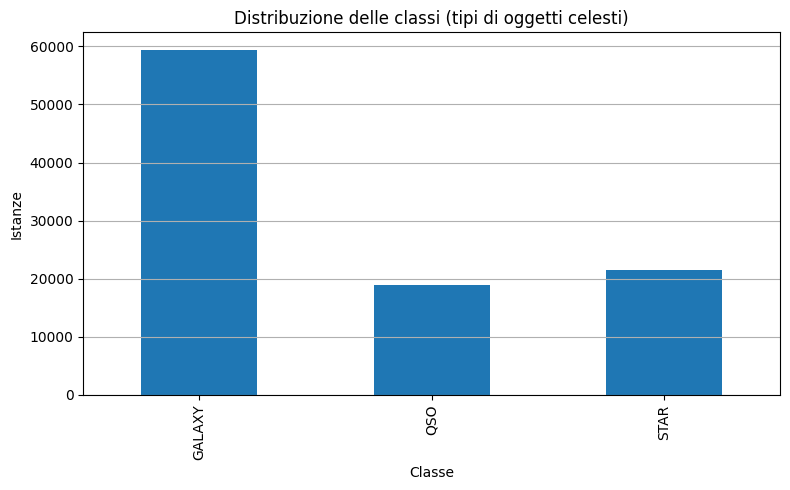

In [170]:
plt.figure(figsize=(8, 5))
df['class'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribuzione delle classi (tipi di oggetti celesti)')
plt.xlabel('Classe')
plt.ylabel('Istanze')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Grafico a torta**

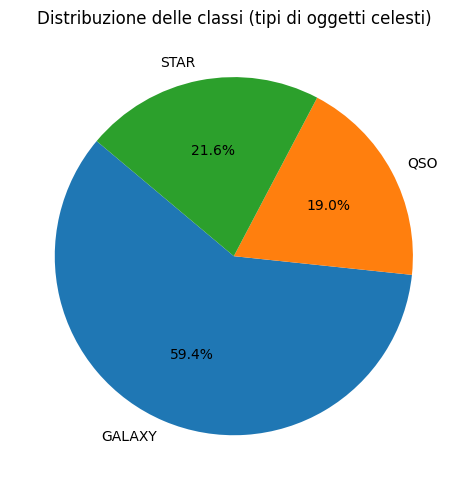

In [171]:
classes = df['class'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
classes.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribuzione delle classi (tipi di oggetti celesti)')
plt.ylabel('')
plt.tight_layout()
plt.show()

Osservando i grafici possiamo notare che le classi non sono bilanciate, con una predominanza di galassie (circa il 60%) rispetto a stelle e quasar (circa il 20% l'uno). 

## 2. Analisi esplorativa

Otteniamo informazioni di base e statistiche sul dataset.

In [172]:
df.describe()

,object_id,right_ascension,declination,ultraviolet_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,run_id,rerun_id,camera_column,field_id,spec_object_id,redshift,plate,modified_julian_date,fiber_id
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


### Presenza di duplicati


Controllare la presenza di duplicati basati su **spec_object_id** è fondamentale per garantire l'integrità del dataset. Come citato nella documentazione 2 osservazioni diverse con lo stesso spec_obj_ID devono condividere la stessa classe di output. Pertanto, è importante identificare e gestire eventuali duplicati nel dataset prima di procedere con l'addestramento del modello.

In [173]:
# Verifica duplicati basati su spec_object_id (come menzionato nella documentazione)
print("Duplicati basati su spec_object_id:")
duplicates = df[df.duplicated(subset=['spec_object_id'], keep=False)]
print(f"Numero di righe duplicate: {len(duplicates)}")

# Verifica duplicati completi
print(f"\nDuplicati completi (righe identiche del dataset): {df.duplicated().sum()}")

Duplicati basati su spec_object_id:
Numero di righe duplicate: 0

Duplicati completi (righe identiche del dataset): 0


Come possiamo osservare non ci sono duplicati basati su spec_object_ID e neanche duplicati completi con tutte le colonne identiche.

### Rimozione di colonne non rilevanti per la classificazione

Alcune colonne sono semplicemente ID univoci o informazioni tecniche e non forniscono informazioni utili per la classificazione. Queste colonne possono essere rimosse per semplificare il dataset.

In [174]:
features_to_drop = ["object_id", "spec_object_id", "run_id", "field_id", "plate", "fiber_id"]
df = df.drop(columns=features_to_drop)

La feature **rerun_id** è sempre uguale a 301 quindi posso rimuoverla in quanto non apporta informazioni utili alla classificazione degli oggetti celesti.

In [175]:
df = df.drop(columns=['rerun_id'])

### Analisi degli outliers

Analizziamo gli outliers per le features numeriche principali.

In [176]:
numeric_features = ['ultraviolet_filter', 'green_filter', 'red_filter', 
                   'near_infrared_filter', 'infrared_filter', 'redshift']


Definiamo una funzione visualizzare i box diagram.

In [177]:
def plot_box_diagram(features):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        df.boxplot(column=feature, by='class', ax=axes[i])
        axes[i].set_title(f'{feature} by class')
        
    plt.tight_layout()
    plt.show()

Definiamo una funzione per visualizzare la distribuzione delle features.

In [178]:
def plot_feature_distribution(features):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for i, feature in enumerate(features):
        ax = axes[i // 3, i % 3]
        sns.histplot(df[feature], bins=30, kde=True, ax=ax)
        ax.set_title(f'Distribuzione della caratteristica: {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequenza')
        ax.grid()
    plt.tight_layout()
    plt.show()

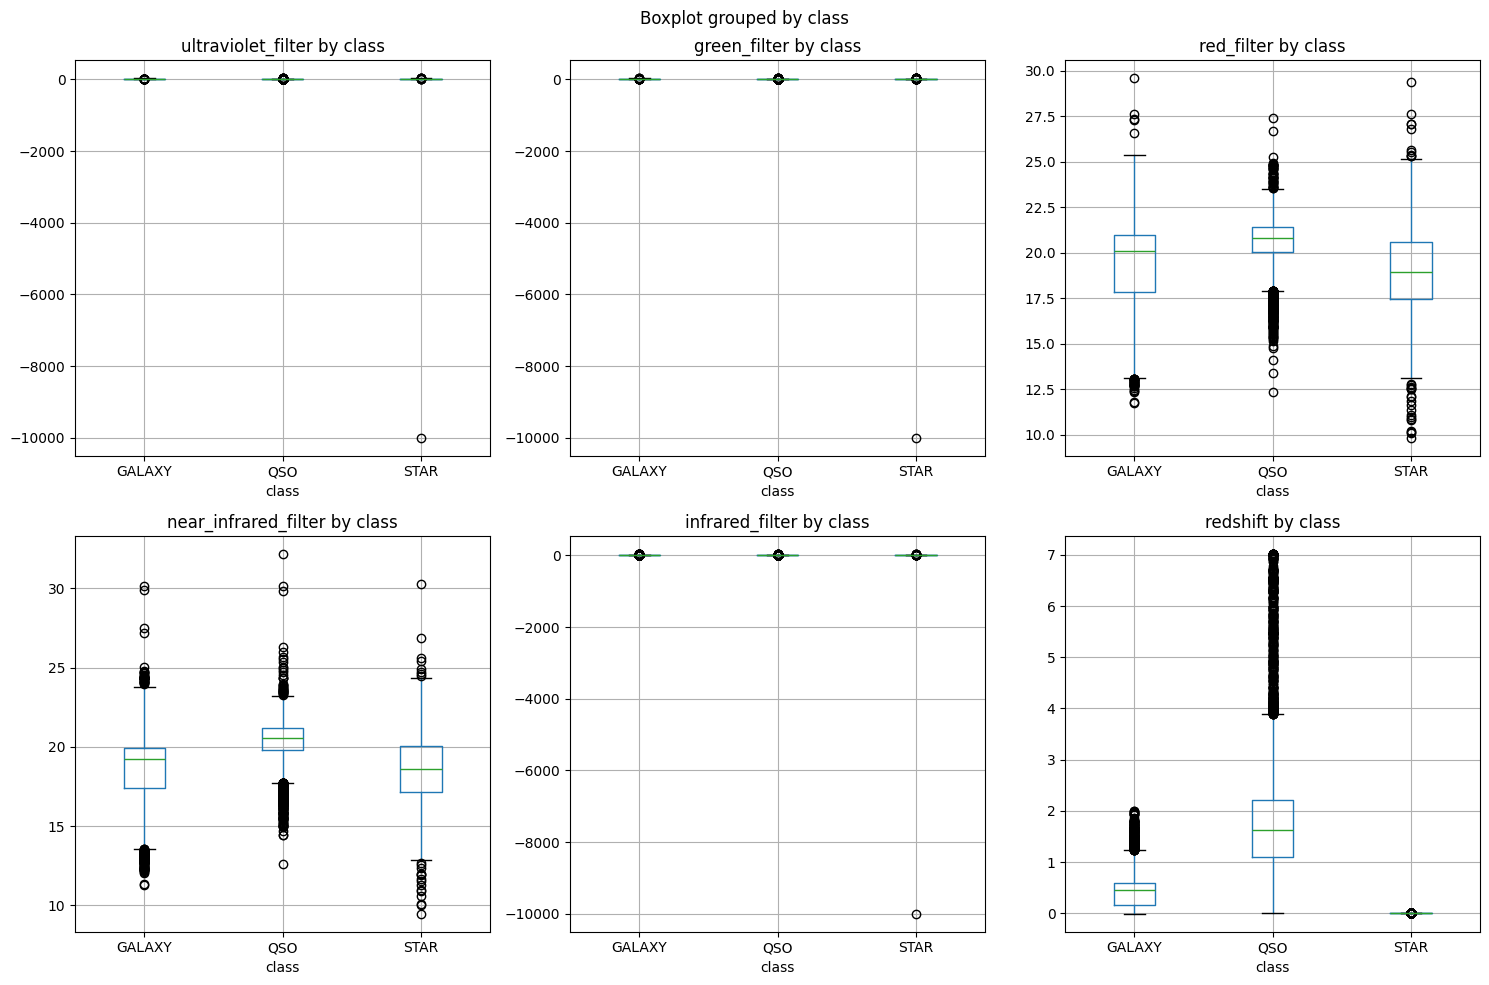

In [179]:
plot_box_diagram(numeric_features)

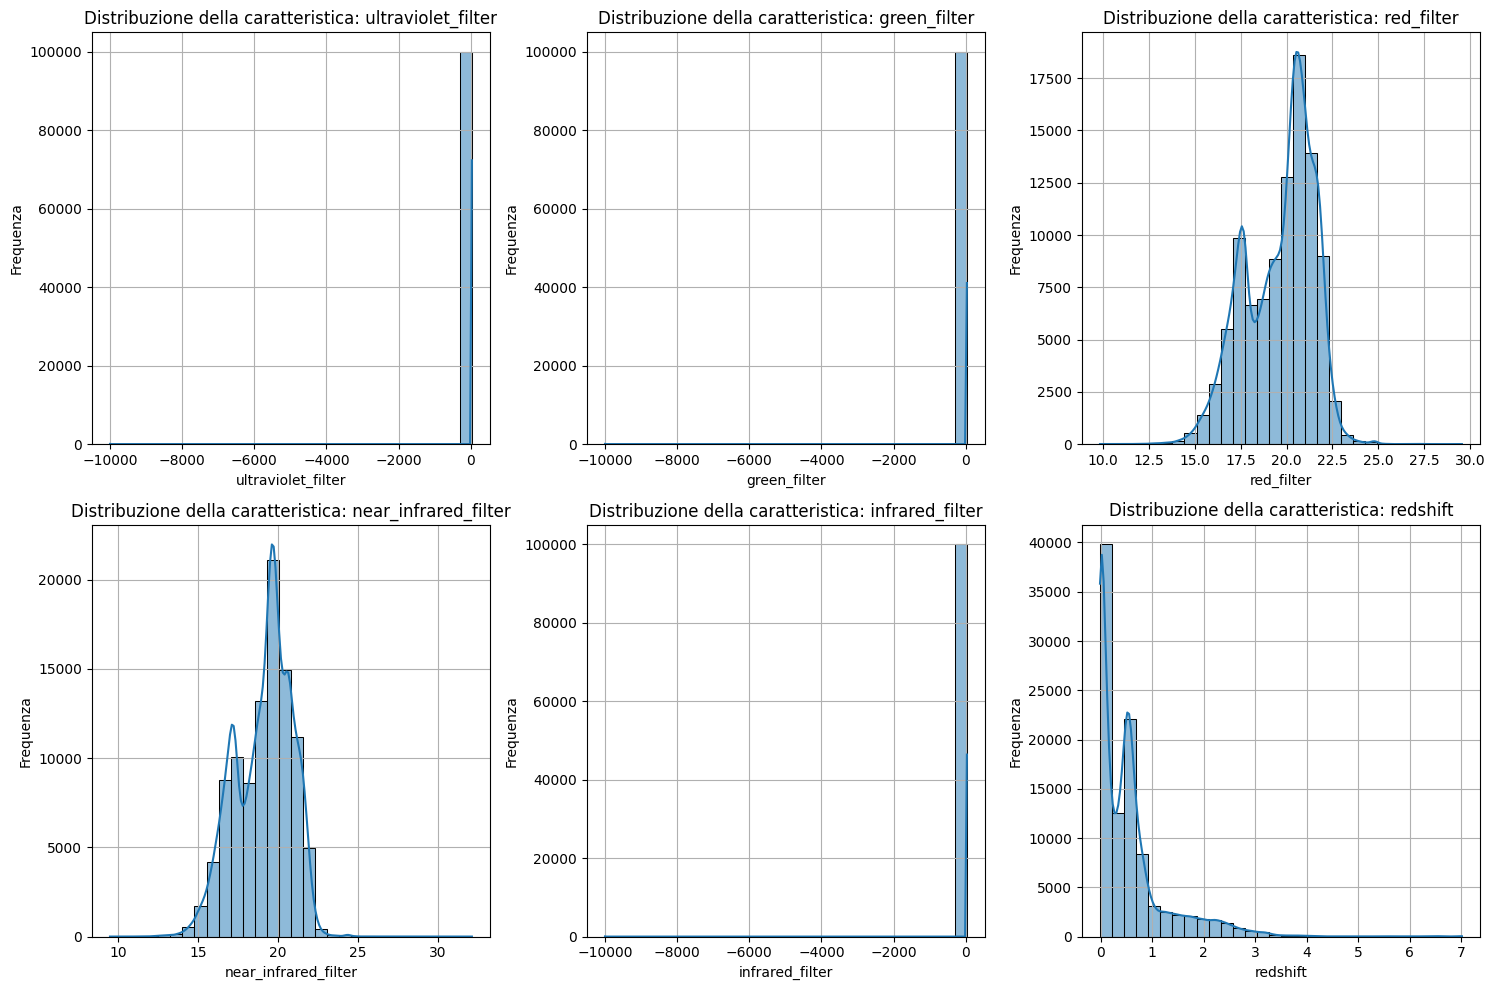

In [180]:
plot_feature_distribution(numeric_features)

Possiamo notare che per le features "ultraviolet_filter", "green_filter", e "infrared_filter" ci sono valori anomali -9999.
Procediamo a rimuovere questi valori dal nostro dataframe, in quanto potrebbero essere stati inseriti come placeholder di dati mancanti.


In [181]:
# rimozione righe outliers
df = df[(df[['ultraviolet_filter', 'green_filter', 'infrared_filter']] != -9999).all(axis=1)]


Facciamo il plot dei box diagram e degli istogrammi dopo aver rimosso i valori anomali.

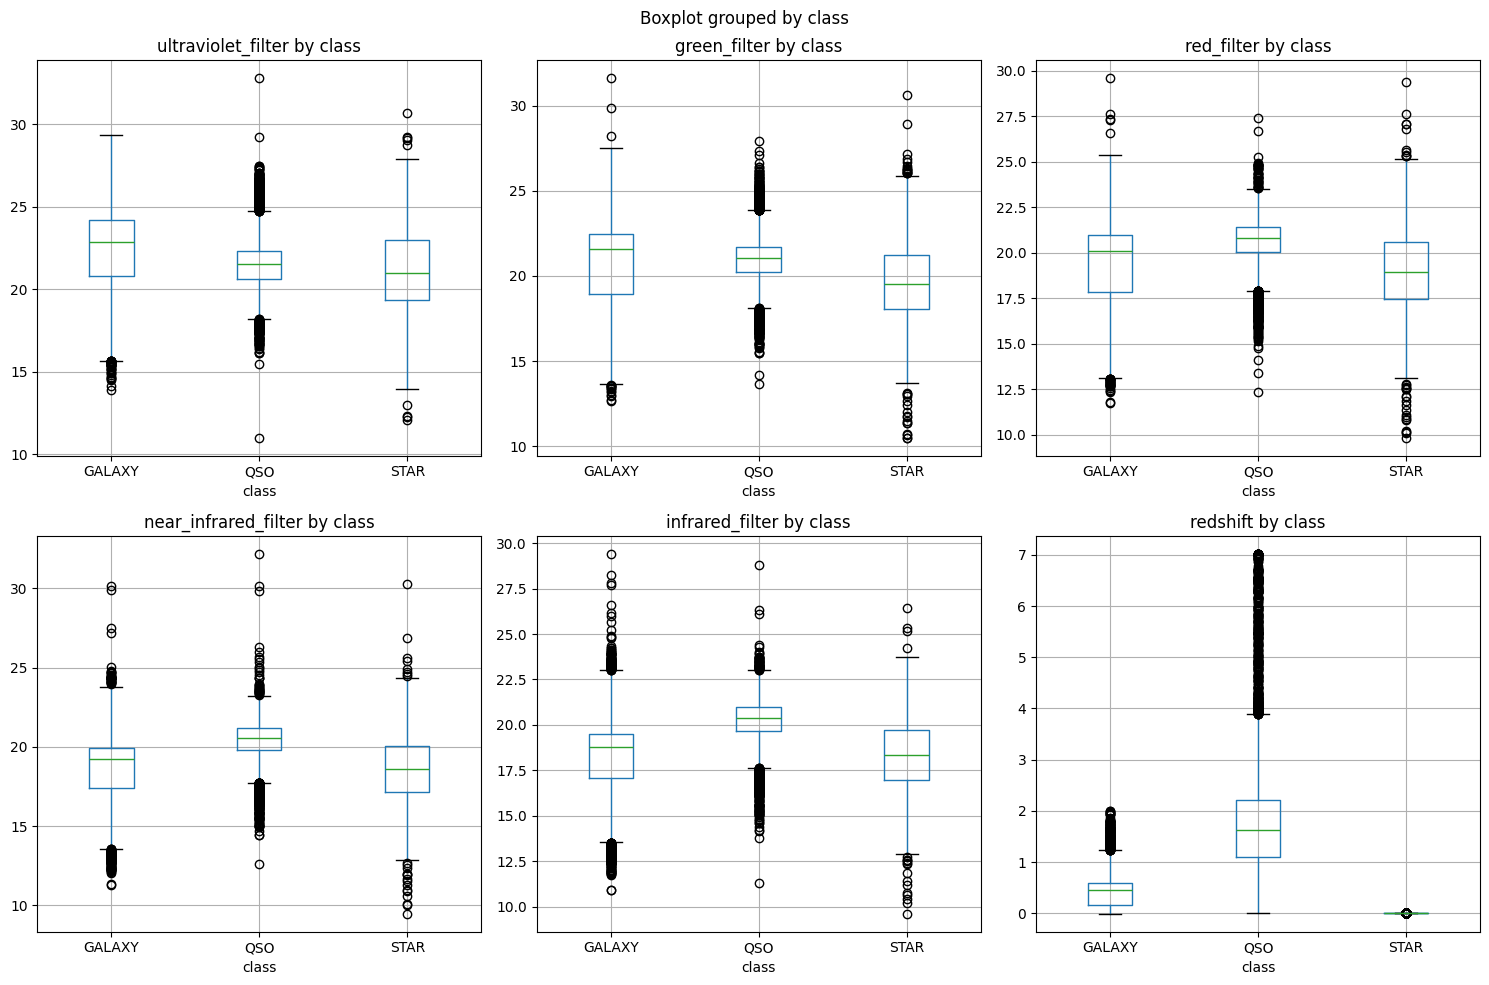

In [182]:
plot_box_diagram(numeric_features)

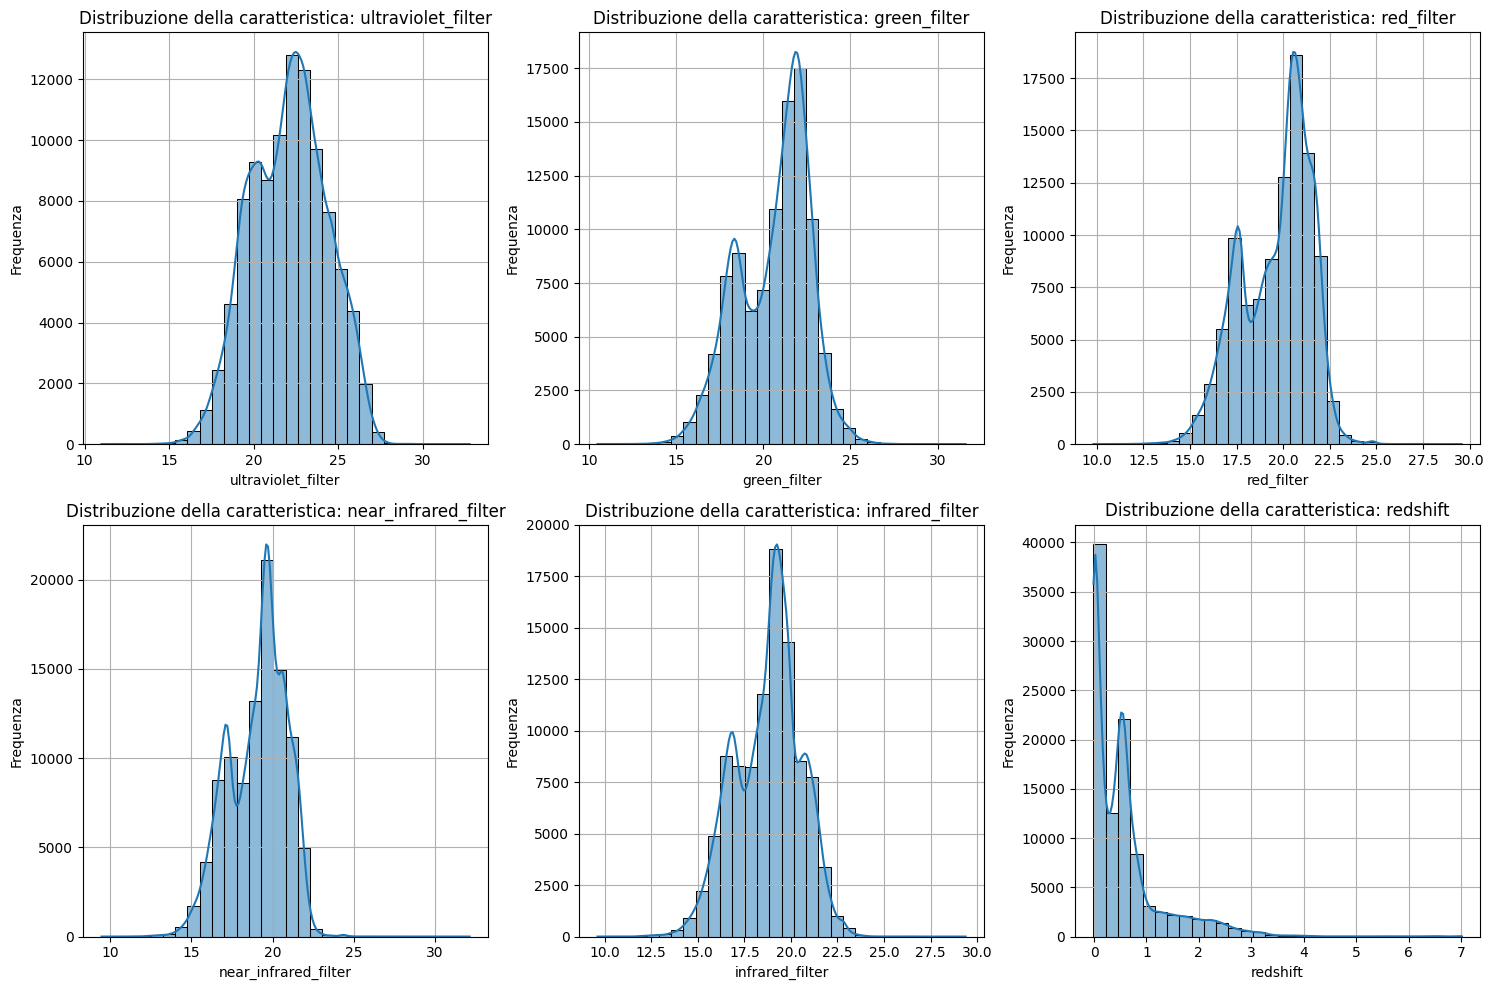

In [183]:
plot_feature_distribution(numeric_features)

Ricalcoliamo le statistiche descrittive del dataframe aggiornato senza valori anomali.

In [184]:
df.describe()

,right_ascension,declination,ultraviolet_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,camera_column,redshift,modified_julian_date
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,3.511625,0.576667,55588.653687
std,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,1.586913,0.730709,1808.492217
min,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,1.000000,-0.009971,51608.000000
25%,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,2.000000,0.054522,54234.000000
50%,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,4.000000,0.424176,55869.000000
75%,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,5.000000,0.704172,56777.000000
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,6.000000,7.011245,58932.000000


### Osservazioni dei grafici

Possiamo osservare che la feature **redshift** è probabilmente quella più discriminante tra le tre classi, in quanto:
- Stelle hanno un valore prossimo a 0
- Galassie hanno un valore compreso tra 0 e 1
- Quasar hanno un valore superiore a 1 (fino a 7 per quelli molto lontani)

### Feature Engineering

Utilizzando le magnitudini di u, g, r, i, z, posso creare i [color indices](https://en.wikipedia.org/wiki/Color_index):

- **u-g**: differenza di magnitudine tra le bande u e g
- **g-r**: differenza di magnitudine tra le bande g e r
- **r-i**: differenza di magnitudine tra le bande r e i
- **i-z**: differenza di magnitudine tra le bande i e z

Questi **indici di colore** sono molto utilizzati in astronomia e  forniscono informazioni preziose sulla temperatura e sulla composizione degli oggetti celesti.

In [185]:
df['color_u_g'] = df['ultraviolet_filter'] - df['green_filter']
df['color_g_r'] = df['green_filter'] - df['red_filter']
df['color_r_i'] = df['red_filter'] - df['near_infrared_filter']
df['color_i_z'] = df['near_infrared_filter'] - df['infrared_filter']

In [186]:
df.head()

,right_ascension,declination,ultraviolet_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,camera_column,class,redshift,modified_julian_date,color_u_g,color_g_r,color_r_i,color_i_z
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,GALAXY,0.634794,56354,1.60352,1.88029,1.22928,0.37202
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,GALAXY,0.779136,58158,1.94571,0.24744,1.41632,-0.44615
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,GALAXY,0.644195,55592,2.59918,2.05413,1.26119,0.40030
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,GALAXY,0.932346,58039,-1.63974,2.16494,1.10708,1.25444
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,GALAXY,0.116123,56187,1.85690,1.08281,0.52036,0.43250


Per capire meglio come sono legate tra di loro le feature, visualizziamo la **matrice di correlazione**.

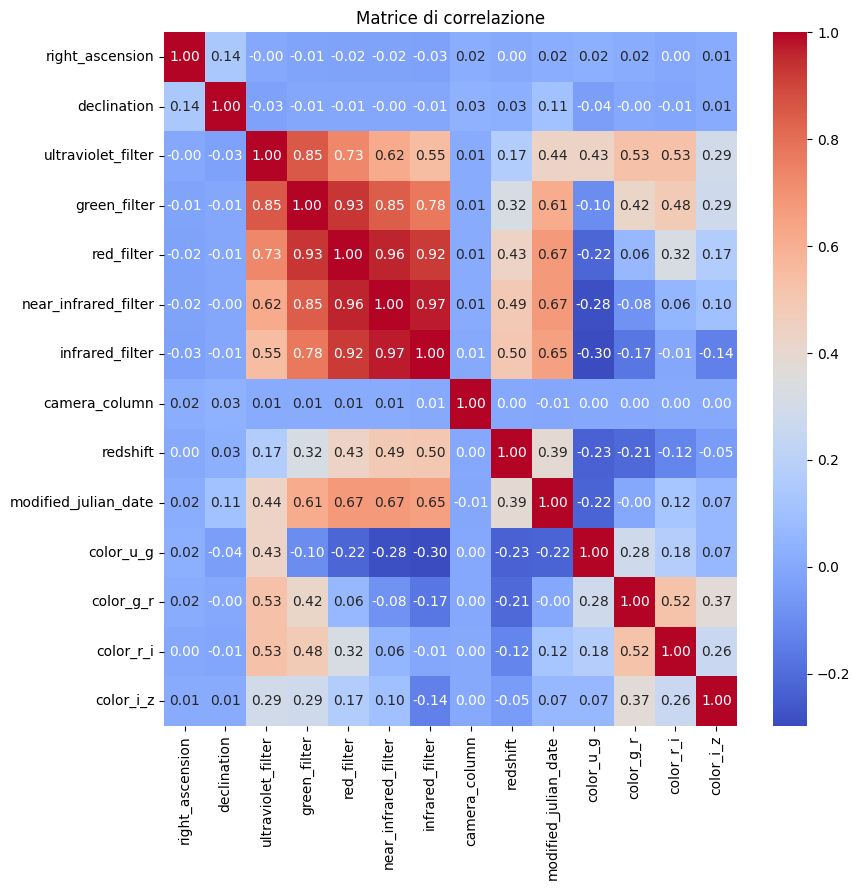

In [187]:
# Matrice di correlazione 
plt.figure(figsize=(9, 9))
# tolgo il target 'class'
features_order = [
    "right_ascension", "declination", "ultraviolet_filter", "green_filter", "red_filter", "near_infrared_filter", "infrared_filter", "camera_column", "redshift", "modified_julian_date", "color_u_g", "color_g_r", "color_r_i", "color_i_z"
]
correlation_matrix = df[features_order].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')


plt.title('Matrice di correlazione')
plt.tight_layout()
plt.show()


Dalla matrice di correlazione osserviamo che le magnitudini nelle bande ottiche **(ultraviolet_filter, green_filter, red_filter, infrared_filter, near_infrared_filter)** sono fortemente correlate tra loro, il che è atteso in quanto rappresentano misurazioni della stessa sorgente in diverse lunghezze d'onda. 

Le features aggiunte per i **color index** mostrano correlazioni moderate con i filtri ottici, il che suggerisce che le informazioni spettrali contenute in queste bande sono utili per la classificazione degli oggetti celesti.

Per quanto riguarda la modified_julian_date, sembra essere correlata positivamente con le magnitudini nelle bande ottiche, probabilmente dovuto a variazioni strumentali nel tempo.

## 3. Preparazione dei dati per il modello

A questo punto, i dati sono pronti per essere utilizzati nel modello di classificazione. Possiamo procedere con la separazione delle feature e della variabile target.


### Preprocessing

Definisco una funzione che crea un dataset bilanciato con lo stesso numero di campioni per ogni classe.

In [188]:
def create_balanced_sample(df, n_per_class, random_state=42):
    """
    Crea un campione bilanciato prendendo n_per_class istanze da ogni classe
    """
    balanced_dfs = []
    for class_name in df['class'].unique():
        class_df = df[df['class'] == class_name].sample(n=n_per_class, random_state=random_state)
        balanced_dfs.append(class_df)
    
    return pd.concat(balanced_dfs, ignore_index=True).sample(frac=1, random_state=random_state)


Prendo in considerazione 10000 campioni per ogni classe.

In [189]:
# dato che il dataset ha troppe istanze prendo 30k righe per facilitare il training
df_balanced = create_balanced_sample(df, n_per_class=10_000, random_state=42)

Separo le features dalla variabile target.

In [190]:
X = df_balanced.drop(columns=["class"])
y = df_balanced["class"]

Utilizzo **LabelEncoder** per codificare le etichette delle classi.

In [191]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [192]:
# Verifichiamo la mappatura delle classi
print("Mappatura delle classi:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

# Verifichiamo la distribuzione dopo il sampling
print("\nDistribuzione delle classi nel dataset ridotto:")
print(pd.Series(y).value_counts().sort_index())

Mappatura delle classi:
0: GALAXY
1: QSO
2: STAR

Distribuzione delle classi nel dataset ridotto:
class
GALAXY    10000
QSO       10000
STAR      10000
Name: count, dtype: int64


### Divisione dataset in train e test

Divido il dataset in un insieme di addestramento (80%) e uno di test (20%).

In [193]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [194]:
print(f"Dimensioni training set: {X_train.shape}")
print(f"Dimensioni test set: {X_test.shape}")

# Verifica distribuzione classi nel training set
print("\nDistribuzione classi nel training set:")
unique, counts = np.unique(y_train, return_counts=True)
for i, (cls, count) in enumerate(zip(unique, counts)):
    print(f"Classe {cls} ({label_encoder.classes_[cls]}): {count} ({count/len(y_train)*100:.1f}%)")

Dimensioni training set: (24000, 14)
Dimensioni test set: (6000, 14)

Distribuzione classi nel training set:
Classe 0 (GALAXY): 8000 (33.3%)
Classe 1 (QSO): 8000 (33.3%)
Classe 2 (STAR): 8000 (33.3%)


In [195]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. Addestramento e validazione dei modelli

Per il training dei modelli vengono utilizzati due dataset: uno bilanciato (con lo stesso numero di campioni per ogni classe) e uno sbilanciato (con campioni che rispettano le proporzioni originali). Questo ci permette di confrontare le performance dei modelli in scenari diversi.

### Definizione modelli

Addestriamo alcuni modelli di classificazione.
Ho utilizzato algoritmi di diverse famiglie:
- Logistic Regression
- K-Nearest Neighbors
- Random Forest
- XGBoost

In [196]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

Definisco una funzione per addestrare e valutare i vari modelli.

Vengono calcolati:
- Accuratezza
- Precisione
- Richiamo
- F1-Score

Viene inoltre effettuata la cross-validation per garantire che i modelli generalizzino bene su dati non visti.

In [197]:
# Funzione per valutare i modelli
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, plot_image=True):
    # Addestramento
    model.fit(X_train, y_train)
    
    # Predizioni
    y_pred = model.predict(X_test)
    
    #Metriche
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    print(f"\n{'='*50}")
    print(f"MODELLO: {model_name}")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Matrice di confusione
    if plot_image:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f'Matrice di Confusione - {model_name}')
        plt.ylabel('Classe Reale')
        plt.xlabel('Classe Predetta')
        plt.show()
        
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

### Dataset bilanciato

Addestro e calcolo le metriche di valutazione per ogni modello.


MODELLO: Logistic Regression
Accuracy: 0.9483
Precision (weighted): 0.9481
Recall (weighted): 0.9483
F1-Score (weighted): 0.9480
Cross-validation accuracy: 0.9460 (+/- 0.0037)


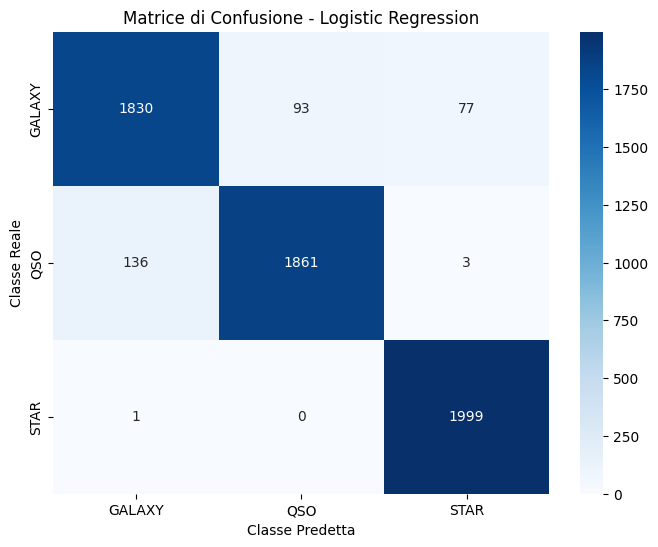


Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.93      0.92      0.92      2000
         QSO       0.95      0.93      0.94      2000
        STAR       0.96      1.00      0.98      2000

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000


MODELLO: K-Nearest Neighbors
Accuracy: 0.9147
Precision (weighted): 0.9170
Recall (weighted): 0.9147
F1-Score (weighted): 0.9152
Cross-validation accuracy: 0.9093 (+/- 0.0067)


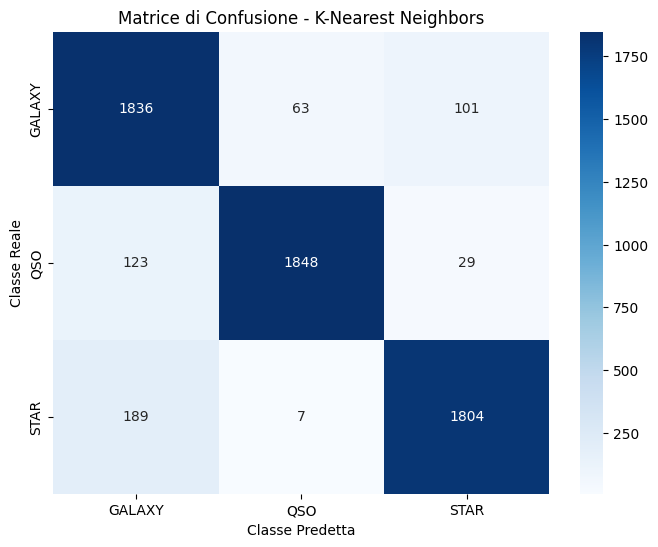


Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.85      0.92      0.89      2000
         QSO       0.96      0.92      0.94      2000
        STAR       0.93      0.90      0.92      2000

    accuracy                           0.91      6000
   macro avg       0.92      0.91      0.92      6000
weighted avg       0.92      0.91      0.92      6000


MODELLO: Random Forest
Accuracy: 0.9733
Precision (weighted): 0.9733
Recall (weighted): 0.9733
F1-Score (weighted): 0.9733
Cross-validation accuracy: 0.9740 (+/- 0.0020)


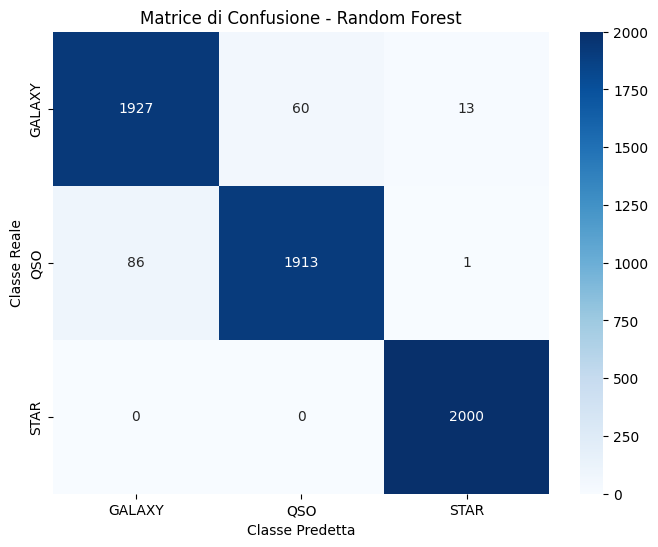


Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96      2000
         QSO       0.97      0.96      0.96      2000
        STAR       0.99      1.00      1.00      2000

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000


MODELLO: XGBoost
Accuracy: 0.9745
Precision (weighted): 0.9746
Recall (weighted): 0.9745
F1-Score (weighted): 0.9745
Cross-validation accuracy: 0.9744 (+/- 0.0020)


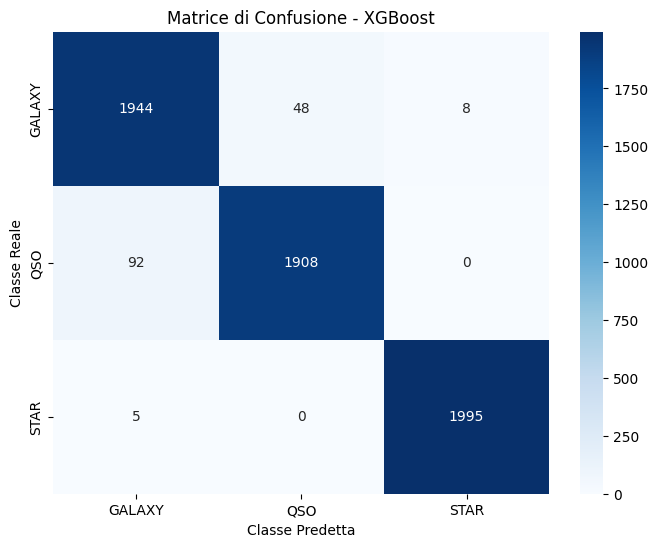


Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.95      0.97      0.96      2000
         QSO       0.98      0.95      0.96      2000
        STAR       1.00      1.00      1.00      2000

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



In [198]:
# Addestramento e valutazione di tutti i modelli
results_balanced = {}

for name, model in models.items():
    results_balanced[name] = evaluate_model(
        model, X_train, y_train, 
        X_test, y_test, name
    )


### Confronto e analisi dei risultati

Confronto le performance e i risultati dei modelli addestrati.

CONFRONTO DELLE PERFORMANCE DEI MODELLI:
                 Model  Accuracy  Precision  Recall  F1-Score  CV Mean  CV Std
0  Logistic Regression    0.9483     0.9481  0.9483    0.9480   0.9460  0.0019
1  K-Nearest Neighbors    0.9147     0.9170  0.9147    0.9152   0.9093  0.0033
2        Random Forest    0.9733     0.9733  0.9733    0.9733   0.9740  0.0010
3              XGBoost    0.9745     0.9746  0.9745    0.9745   0.9744  0.0010


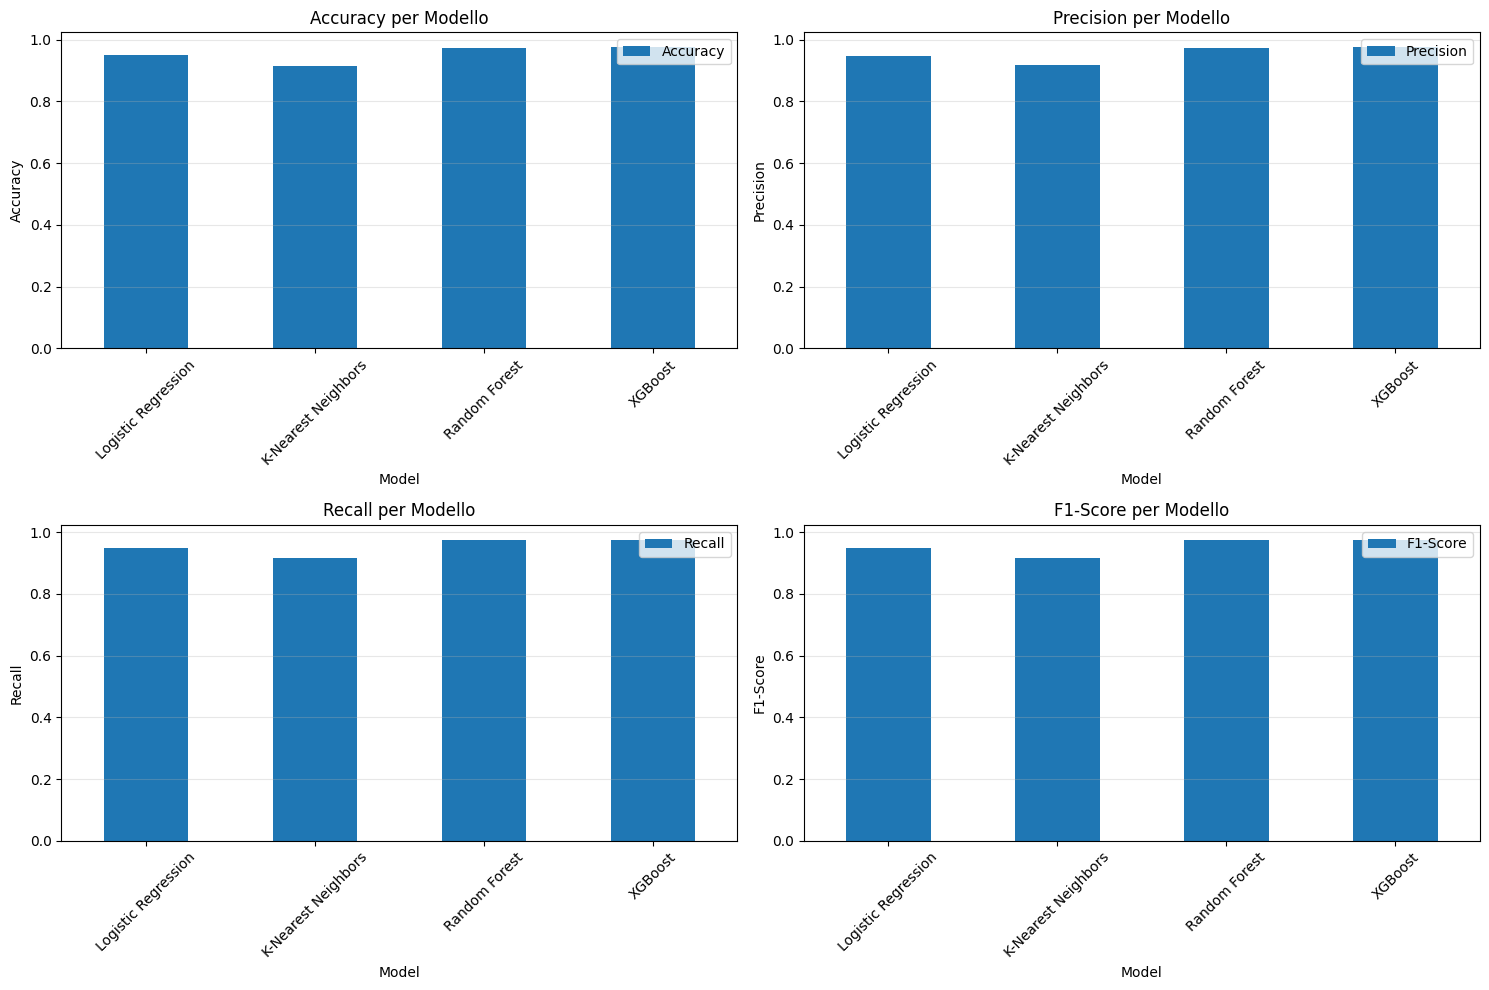

In [199]:
# Confronto delle performance
results_df = pd.DataFrame({
    'Model': list(results_balanced.keys()),
    'Accuracy': [results_balanced[model]['accuracy'] for model in results_balanced],
    'Precision': [results_balanced[model]['precision'] for model in results_balanced],
    'Recall': [results_balanced[model]['recall'] for model in results_balanced],
    'F1-Score': [results_balanced[model]['f1'] for model in results_balanced],
    'CV Mean': [results_balanced[model]['cv_mean'] for model in results_balanced],
    'CV Std': [results_balanced[model]['cv_std'] for model in results_balanced]
})

print("CONFRONTO DELLE PERFORMANCE DEI MODELLI:")
print("="*80)
print(results_df.round(4))

# Visualizzazione delle performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    results_df.plot(x='Model', y=metric, kind='bar', ax=ax)
    ax.set_title(f'{metric} per Modello')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Features più importanti

Di seguito vengono mostrate le features più importati dei due modelli più performati ovvero quelli addestrati con Random Forest e XGBoost.


**Feature Importances XGBoost**

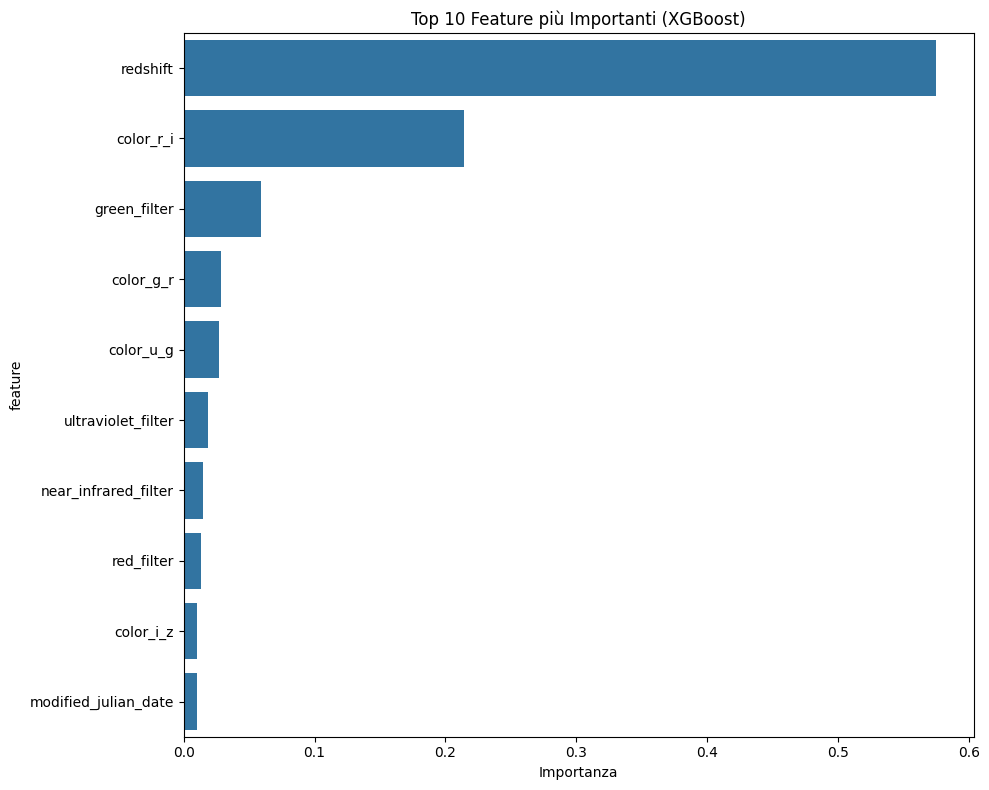

Importanza delle features:
                 feature  importance
8               redshift    0.574897
12             color_r_i    0.214099
3           green_filter    0.058742
11             color_g_r    0.028444
10             color_u_g    0.027320
2     ultraviolet_filter    0.018888
5   near_infrared_filter    0.014563
4             red_filter    0.012925
13             color_i_z    0.010215
9   modified_julian_date    0.010086
6        infrared_filter    0.008872
0        right_ascension    0.007288
1            declination    0.006968
7          camera_column    0.006695


In [200]:
# Analisi dell'importanza delle features per XGBoost
xgb_model = results_balanced['XGBoost']['model']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), y='feature', x='importance')
plt.title('Top 10 Feature più Importanti (XGBoost)')
plt.xlabel('Importanza')
plt.tight_layout()
plt.show()

print("Importanza delle features:")
print(feature_importance)

**Feature Importances Random Forest**

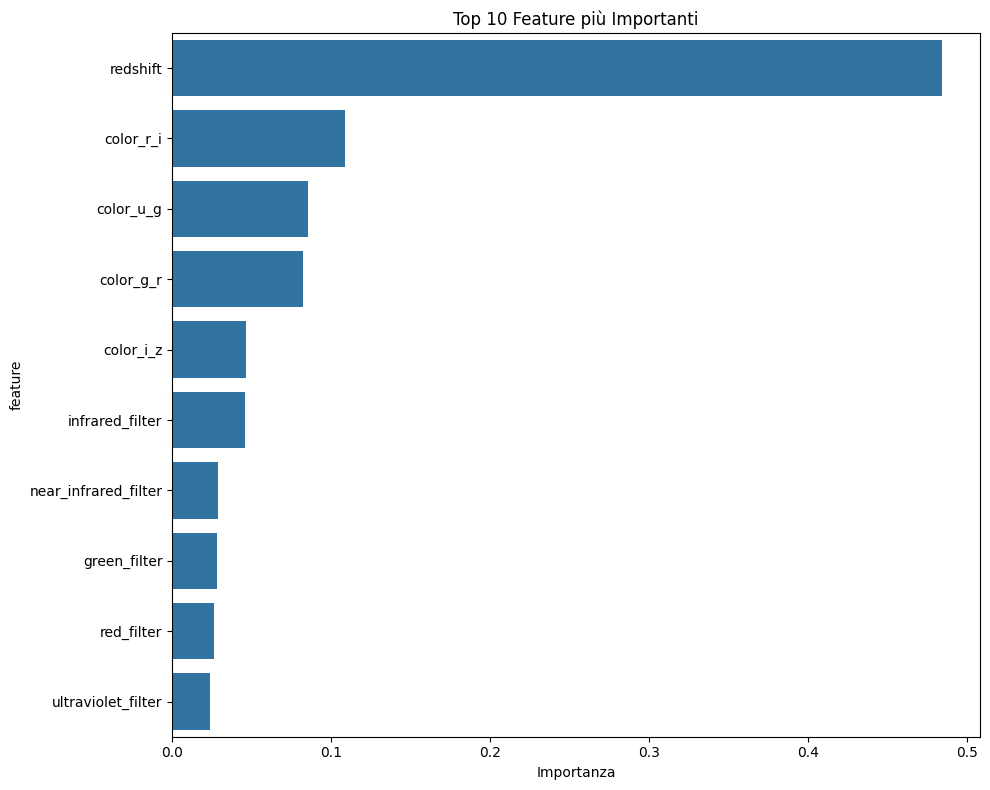

Importanza delle features:
                 feature  importance
8               redshift    0.484203
12             color_r_i    0.108916
10             color_u_g    0.085401
11             color_g_r    0.082235
13             color_i_z    0.046681
6        infrared_filter    0.045487
5   near_infrared_filter    0.029046
3           green_filter    0.028235
4             red_filter    0.026351
2     ultraviolet_filter    0.023657
9   modified_julian_date    0.022905
0        right_ascension    0.007449
1            declination    0.006779
7          camera_column    0.002656


In [201]:
# Analisi dell'importanza delle features per Random Forest
rf_model = results_balanced['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), y='feature', x='importance')
plt.title('Top 10 Feature più Importanti')
plt.xlabel('Importanza')
plt.tight_layout()
plt.show()

print("Importanza delle features:")
print(feature_importance)

Osserviamo che la feature **redshift** è nettamente quella più importante per entrambi i modelli, come ci aspettavamo dalle analisi precedenti.

Per quanto riguarda le feature aggiunte (gli indici di colore), notiamo che hanno avuto un impatto positivo sulle performance dei modelli, contribuendo a migliorare la loro capacità di generalizzazione.


### Dataset sbilanciato

Eseguo un training dei modelli con un dataset sbilanciato che rispetta le proporzioni originali.

Utilizzo lo stesso numero di campioni (30000) con le rispettive percentuali:
- 59% galaxy
- 21% star
- 19% quasar

In [202]:
sample_size = 30_000

In [203]:
df_unbalanced = df.sample(n=min(sample_size, len(df)), random_state=42)

In [204]:
print("Distribuzione originale:")
print(df_unbalanced['class'].value_counts(normalize=True))

Distribuzione originale:
class
GALAXY    0.593867
STAR      0.214733
QSO       0.191400
Name: proportion, dtype: float64


Separo le features dalla variabile target.

In [205]:
X = df_unbalanced.drop(columns=["class"])
y = df_unbalanced["class"]

In [206]:
y_encoded = label_encoder.fit_transform(y)

In [207]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [208]:
# Scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [209]:
print(f"\nDimensioni training set sbilanciato: {X_train.shape}")
print("Distribuzione classi nel training set sbilanciato:")
unique, counts = np.unique(y_train, return_counts=True)
for i, (cls, count) in enumerate(zip(unique, counts)):
    print(f"Classe {cls} ({label_encoder.classes_[cls]}): {count} ({count/len(y_train)*100:.1f}%)")


Dimensioni training set sbilanciato: (24000, 14)
Distribuzione classi nel training set sbilanciato:
Classe 0 (GALAXY): 14253 (59.4%)
Classe 1 (QSO): 4593 (19.1%)
Classe 2 (STAR): 5154 (21.5%)


Addestro i modelli con il dataset sbilanciato.


MODELLO: Logistic Regression
Accuracy: 0.9533
Precision (weighted): 0.9533
Recall (weighted): 0.9533
F1-Score (weighted): 0.9530
Cross-validation accuracy: 0.9531 (+/- 0.0064)


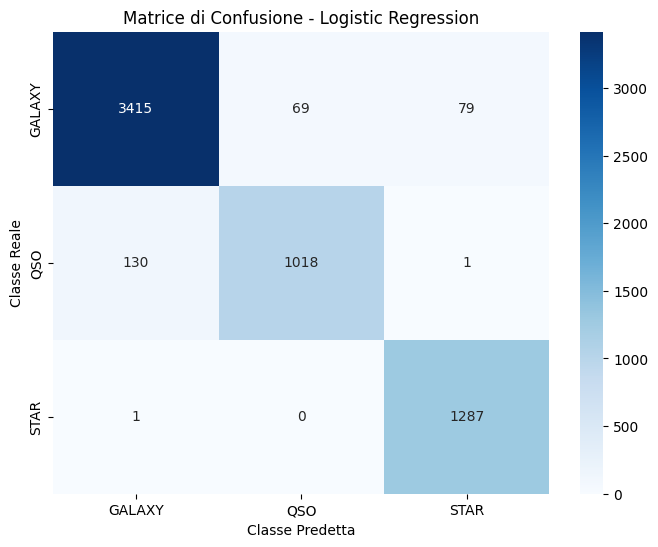


Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96      3563
         QSO       0.94      0.89      0.91      1149
        STAR       0.94      1.00      0.97      1288

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000


MODELLO: K-Nearest Neighbors
Accuracy: 0.9238
Precision (weighted): 0.9243
Recall (weighted): 0.9238
F1-Score (weighted): 0.9231
Cross-validation accuracy: 0.9202 (+/- 0.0040)


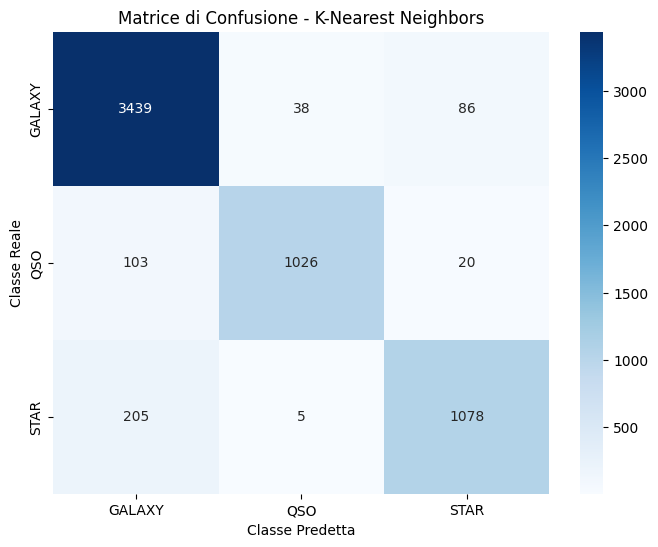


Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.92      0.97      0.94      3563
         QSO       0.96      0.89      0.93      1149
        STAR       0.91      0.84      0.87      1288

    accuracy                           0.92      6000
   macro avg       0.93      0.90      0.91      6000
weighted avg       0.92      0.92      0.92      6000


MODELLO: Random Forest
Accuracy: 0.9757
Precision (weighted): 0.9755
Recall (weighted): 0.9757
F1-Score (weighted): 0.9755
Cross-validation accuracy: 0.9747 (+/- 0.0027)


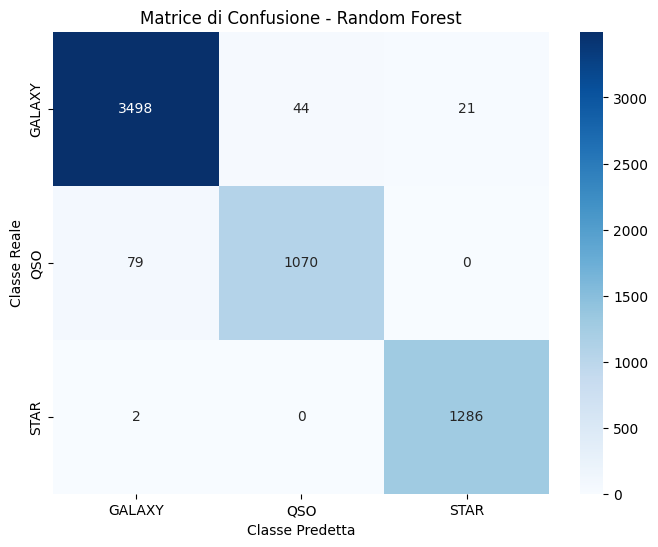


Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      3563
         QSO       0.96      0.93      0.95      1149
        STAR       0.98      1.00      0.99      1288

    accuracy                           0.98      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.98      0.98      0.98      6000


MODELLO: XGBoost
Accuracy: 0.9755
Precision (weighted): 0.9754
Recall (weighted): 0.9755
F1-Score (weighted): 0.9754
Cross-validation accuracy: 0.9767 (+/- 0.0024)


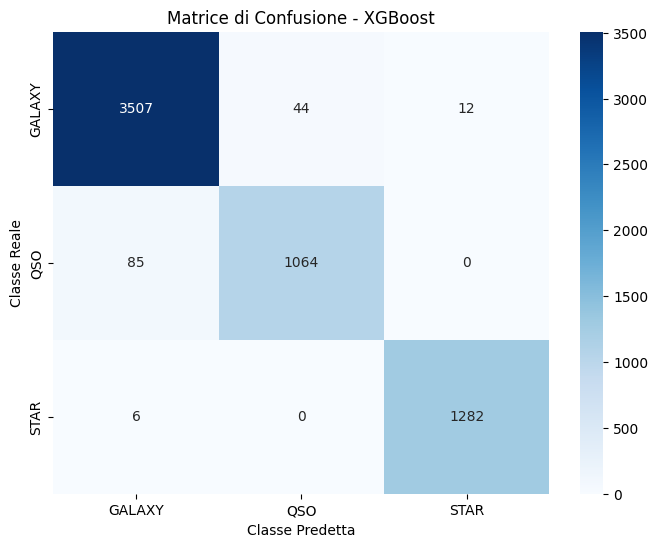


Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98      3563
         QSO       0.96      0.93      0.94      1149
        STAR       0.99      1.00      0.99      1288

    accuracy                           0.98      6000
   macro avg       0.98      0.97      0.97      6000
weighted avg       0.98      0.98      0.98      6000



In [210]:
# Addestramento e valutazione di tutti i modelli
results_unbalanced = {}

for name, model in models.items():
    results_unbalanced[name] = evaluate_model(
        model, X_train, y_train, 
        X_test, y_test, name,
    )

### Confronto dataset bilanciato vs dataset sbilanciato

Definisco una funzione per il confronto tra i modelli addestrati con il dataset bilanciato e i modelli addestrati con il dataset sbilanciato.

In [211]:
# Funzione per confrontare risultati bilanciati vs sbilanciati
def compare_balanced_vs_unbalanced():
    comparison_data = []
    
    # Risultati bilanciati
    for model_name, result in results_balanced.items():
        comparison_data.append({
            'Model': model_name,
            'Dataset': 'Balanced',
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1']
        })
    
    # Risultati sbilanciati
    for model_name, result in results_unbalanced.items():
        comparison_data.append({
            'Model': model_name.replace(' (balanced)', ''),
            'Dataset': 'Unbalanced',
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Visualizzazione
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        sns.barplot(data=comparison_df, x='Model', y=metric, hue='Dataset', ax=ax)
        ax.set_title(f'{metric}: Balanced vs Unbalanced')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

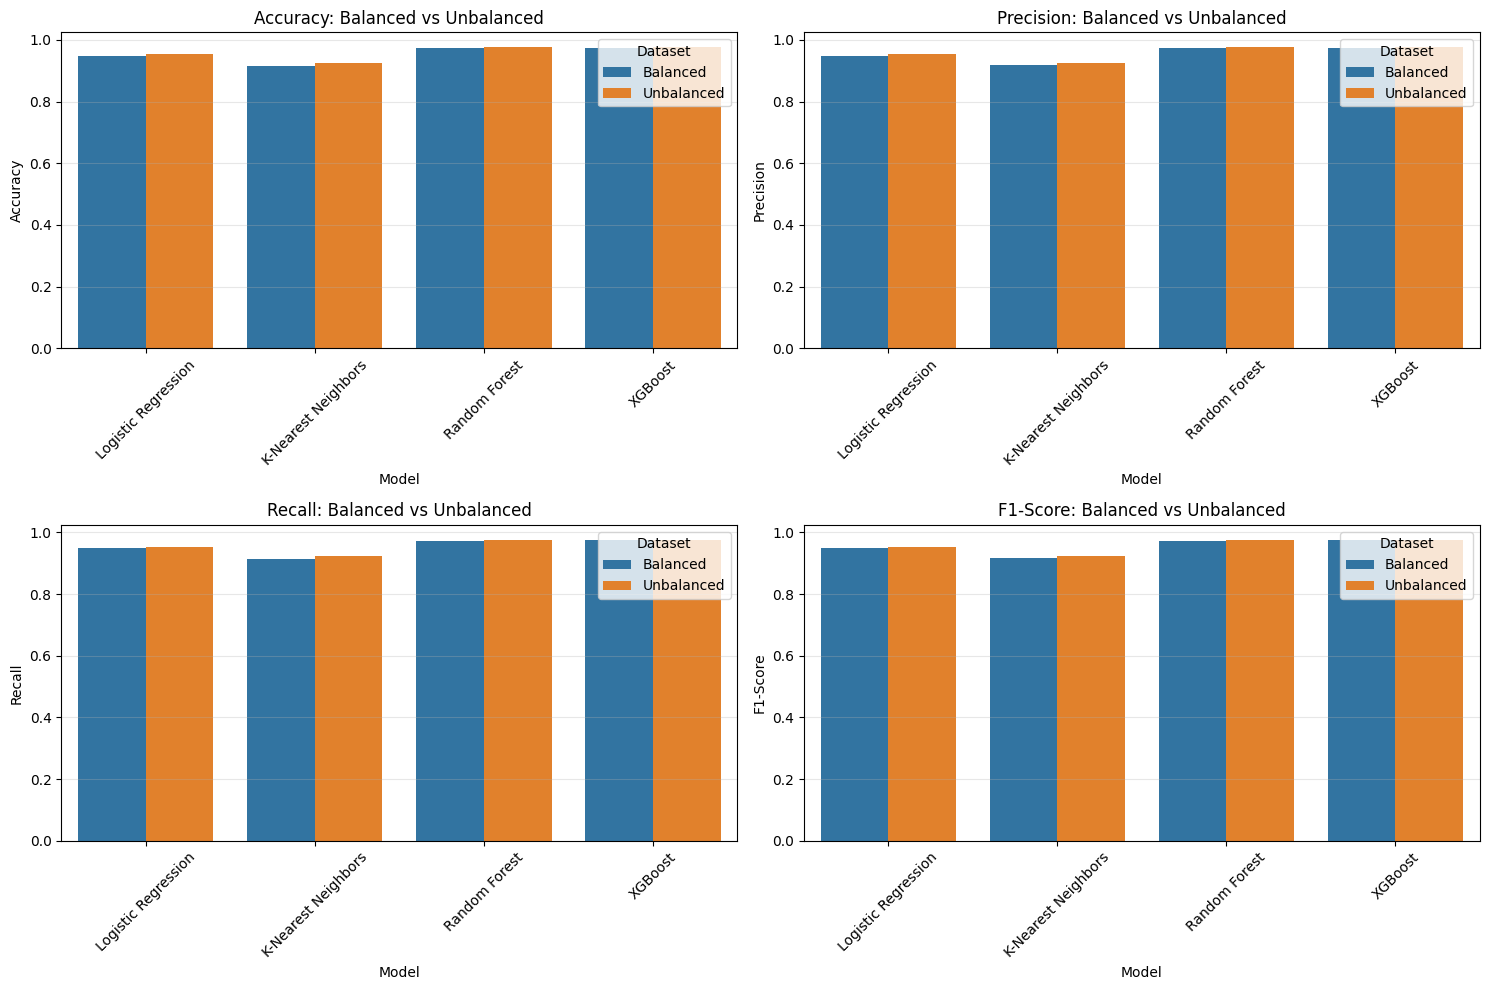

In [212]:
# Esegui il confronto
comparison_results = compare_balanced_vs_unbalanced()

Recap dei risultati.

In [213]:
comparison_results.round(4)

,Model,Dataset,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,Balanced,0.9483,0.9481,0.9483,0.9480
1,K-Nearest Neighbors,Balanced,0.9147,0.9170,0.9147,0.9152
2,Random Forest,Balanced,0.9733,0.9733,0.9733,0.9733
3,XGBoost,Balanced,0.9745,0.9746,0.9745,0.9745
4,Logistic Regression,Unbalanced,0.9533,0.9533,0.9533,0.9530
5,K-Nearest Neighbors,Unbalanced,0.9238,0.9243,0.9238,0.9231
6,Random Forest,Unbalanced,0.9757,0.9755,0.9757,0.9755
7,XGBoost,Unbalanced,0.9755,0.9754,0.9755,0.9754


Osservando i risultati possiamo notare che la differenza di performance tra i modelli addestrati con il dataset sbilanciato (che rispetta le proporzioni originali) e quelli addestrati con il dataset bilanciato è minima.
Questo significa che i modelli sono robusti e hanno buone prestazioni in entrambi i casi.


## 5. Ricerca Iperparametri

Eseguo una ricerca degli iperparametri sui modelli utilizzati.

Effettuo una grid search per ottimizzare gli iperparametri dei modelli.

Per il modello **Logistic Regression** ho valutato:
- C (iperparametro di regolarizzazione)
- penalty (tipo di penalizzazione)
- solver (algoritmo di ottimizzazione utilizzato internamente)
- max_iter (numero massimo di iterazioni per l'ottimizzazione)

Per il modello **K-Nearest Neighbors** ho valutato:
- n_neighbors (numero di vicini da considerare)
- weights (funzione di pesatura dei vicini)
- metric (metrica utilizzata per calcolare la distanza)

Per il modello **Random Forest** ho valutato:
- n_estimators (numero di alberi nella foresta)
- max_depth (profondità massima degli alberi)
- max_features (numero massimo di caratteristiche da considerare per la suddivisione)
- min_samples_split (numero minimo di campioni richiesti per suddividere un nodo)

Per il modello **XGBoost** ho valutato:
- n_estimators (numero di round di boosting)
- max_depth (profondità massima del primo albero)
- learning_rate (tasso di apprendimento)
- subsample (percentuale di campioni da utilizzare per ogni albero)


In [214]:
# Definizione dei parametri per GridSearch per ogni modello
param_grids = {
    'Logistic Regression': {
        'C': [1, 3, 5, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 300]
    },
    
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
}

Definisco una funzione per la ricerca degli iperparametri con grid search.
Si utilizza cross validation a 5 fold, n_jobs viene impostato a -1 per utilizzare tutti i core disponibili.

In [215]:
# Funzione per eseguire GridSearch
def perform_grid_search(models, param_grids, X_train, y_train, cv=5, scoring='accuracy'):
    best_models = {}
    grid_results = {}
    
    for model_name, model in models.items():
        print(f"\n{'='*60}")
        print(f"Grid Search per {model_name}")
        print(f"{'='*60}")
        
        # Configurazione GridSearchCV
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[model_name],
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            verbose=1
        )
        
        # Esecuzione Grid Search
        grid_search.fit(X_train, y_train)
        
        # Salvataggio dei risultati
        best_models[model_name] = grid_search.best_estimator_
        grid_results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'cv_results': grid_search.cv_results_
        }
        
        print(f"Migliori parametri: {grid_search.best_params_}")
        print(f"Miglior score CV: {grid_search.best_score_:.4f}")
        
    return best_models, grid_results


In [216]:

# Esecuzione Grid Search
print("Inizio Grid Search per ottimizzazione iperparametri...")
optimized_models, grid_search_results = perform_grid_search(
    models, param_grids, X_train, y_train, cv=5, scoring='accuracy'
)

Inizio Grid Search per ottimizzazione iperparametri...

Grid Search per Logistic Regression
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Migliori parametri: {'C': 5, 'max_iter': 300, 'penalty': 'l1', 'solver': 'saga'}
Miglior score CV: 0.9534

Grid Search per K-Nearest Neighbors
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Migliori parametri: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Miglior score CV: 0.9288

Grid Search per Random Forest
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Migliori parametri: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Miglior score CV: 0.9747

Grid Search per XGBoost
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Migliori parametri: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Miglior score CV: 0.9770


### Analisi risultati grid search

Utilizzo i modelli ottimizzati con gli iperparametri trovati tramite grid search per valutare le loro prestazioni sul dataset.

**LOGISTIC REGRESSION**

In [217]:
pd.Series(grid_search_results['Logistic Regression']['best_params'])

C              5
max_iter     300
penalty       l1
solver      saga
dtype: object

I parametri migliori sono quindi:
- C: 5
- max_iter: 300
- penalty: l1
- solver: saga

**K-NEAREST NEIGHBORS**

In [218]:
pd.Series(grid_search_results['K-Nearest Neighbors']['best_params'])

metric         manhattan
n_neighbors            7
weights         distance
dtype: object

I parametri migliori sono quindi:
- metric: manhattan
- n_neighbors: 7
- weights: distance


**RANDOM FOREST**


In [219]:
pd.Series(grid_search_results['Random Forest']['best_params'])

max_depth              NaN
min_samples_leaf       1.0
min_samples_split      2.0
n_estimators         100.0
dtype: float64

I parametri migliori sono quindi:
- max_depth: None
- min_samples_leaf: 1.0
- min_samples_split: 2.0
- n_estimators: 100.0


**XBGOOST**

In [220]:
pd.Series(grid_search_results['XGBoost']['best_params'])

learning_rate      0.1
max_depth          6.0
n_estimators     100.0
subsample          0.8
dtype: float64

I parametri migliori sono quindi:
- learning_rate: 0.1
- max_depth: 6
- n_estimators: 100
- subsample: 0.8

Addestro i modelli ottimizzati con i migliori parametri trovati.

In [221]:
optimized_results = {}

for name, model in optimized_models.items():
    optimized_results[name] = evaluate_model(
        model, X_train, y_train, 
        X_test, y_test, f"{name} (Ottimizzato)", plot_image=False
    )


MODELLO: Logistic Regression (Ottimizzato)
Accuracy: 0.9535
Precision (weighted): 0.9535
Recall (weighted): 0.9535
F1-Score (weighted): 0.9532
Cross-validation accuracy: 0.9534 (+/- 0.0065)

Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96      3563
         QSO       0.94      0.89      0.91      1149
        STAR       0.94      1.00      0.97      1288

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000


MODELLO: K-Nearest Neighbors (Ottimizzato)
Accuracy: 0.9298
Precision (weighted): 0.9302
Recall (weighted): 0.9298
F1-Score (weighted): 0.9293
Cross-validation accuracy: 0.9288 (+/- 0.0073)

Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.93      0.97      0.95      3563
         QSO       0.96      0.89      0.92      1149
        STAR       0.92   

Definisco una funzione per fare il confronto tra i modelli ottimizzati e quelli di base (prima della ricerca degli iperparametri).

In [222]:
# Confronto performance: modelli base vs ottimizzati
def compare_base_vs_optimized():
    comparison_data = []
    
    # Risultati modelli base
    for model_name, result in results_balanced.items():
        comparison_data.append({
            'Model': model_name,
            'Type': 'Base',
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1']
        })
    
    # Risultati modelli ottimizzati
    for model_name, result in optimized_results.items():
        comparison_data.append({
            'Model': model_name.replace(' (Ottimizzato)', ''),
            'Type': 'Ottimizzato',
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1-Score': result['f1']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Visualizzazione
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        sns.barplot(data=comparison_df, x='Model', y=metric, hue='Type', ax=ax)
        ax.set_title(f'{metric}: Base vs Ottimizzato')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df


Confronto i modelli.

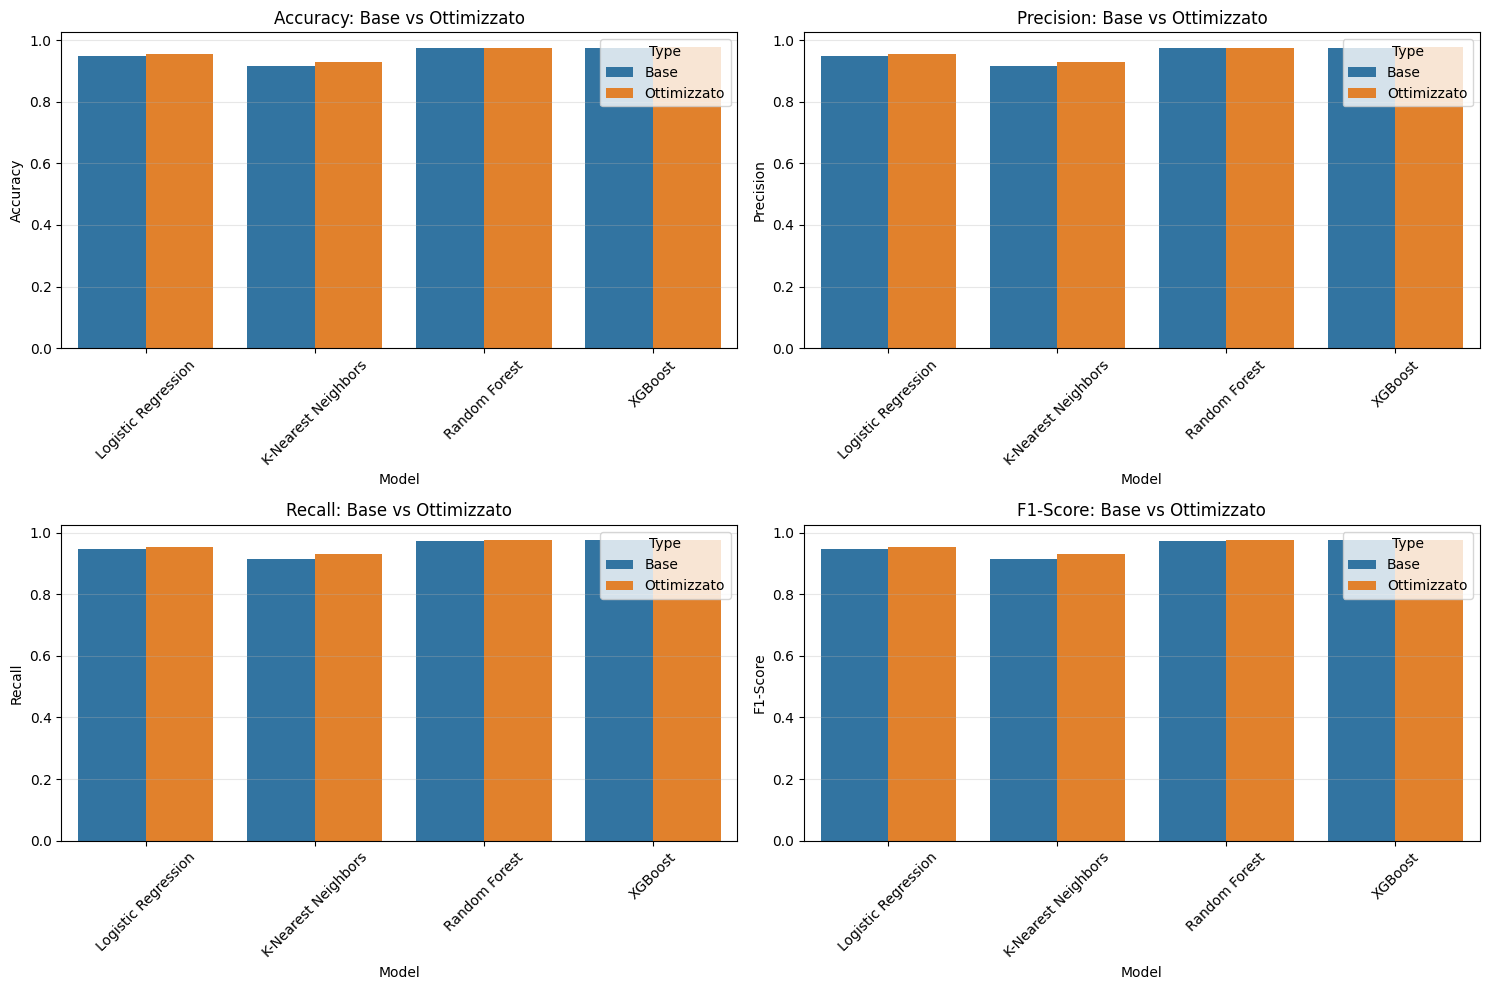

                 Model         Type  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression         Base    0.9483     0.9481  0.9483    0.9480
1  K-Nearest Neighbors         Base    0.9147     0.9170  0.9147    0.9152
2        Random Forest         Base    0.9733     0.9733  0.9733    0.9733
3              XGBoost         Base    0.9745     0.9746  0.9745    0.9745
4  Logistic Regression  Ottimizzato    0.9535     0.9535  0.9535    0.9532
5  K-Nearest Neighbors  Ottimizzato    0.9298     0.9302  0.9298    0.9293
6        Random Forest  Ottimizzato    0.9757     0.9755  0.9757    0.9755
7              XGBoost  Ottimizzato    0.9763     0.9762  0.9763    0.9762


In [223]:
# Esegui il confronto
optimization_comparison = compare_base_vs_optimized()
print(optimization_comparison.round(4))

In [226]:
# Riepilogo miglioramenti
print("\n" + "="*50)
print("RIEPILOGO MIGLIORAMENTI")
print("="*50)

for model_name in models.keys():
    base_accuracy = results_balanced[model_name]['accuracy']
    opt_accuracy = optimized_results[model_name]['accuracy']
    improvement = (opt_accuracy - base_accuracy) * 100
    
    print(f"{model_name}:")
    print(f"  Accuracy Base: {base_accuracy:.4f}")
    print(f"  Accuracy Ottimizzata: {opt_accuracy:.4f}")
    print(f"  Miglioramento: {improvement:+.2f}%")
    print()


RIEPILOGO MIGLIORAMENTI
Logistic Regression:
  Accuracy Base: 0.9483
  Accuracy Ottimizzata: 0.9535
  Miglioramento: +0.52%

K-Nearest Neighbors:
  Accuracy Base: 0.9147
  Accuracy Ottimizzata: 0.9298
  Miglioramento: +1.52%

Random Forest:
  Accuracy Base: 0.9733
  Accuracy Ottimizzata: 0.9757
  Miglioramento: +0.23%

XGBoost:
  Accuracy Base: 0.9745
  Accuracy Ottimizzata: 0.9763
  Miglioramento: +0.18%



Come ci aspettavamo possiamo notare un leggero miglioramento delle prestazioni nei modelli ottimizzati rispetto a quelli di base.

## 6. Conclusioni


In seguito agli esperimenti e alle analisi effettuate possiamo notare che tutti i modelli hanno ottenuto ottimi risultati (sempre > 90%). Sebbene eccellenti, risultati così alti possono essere sospetti e potrebbero indicare un problema di overfitting.

### Segnali positivi contro l'overfitting

1. **Cross-validation**: Utilizzando cross validation a 5 fold, abbiamo potuto verificare la stabilità delle performance dei modelli. I punteggi ottenuti sui vari fold sono stati coerenti, suggerendo che i modelli non si sono adattati eccessivamente ai dati di addestramento.

2. **Dataset bilanciato vs sbilanciato**: Le performance simili dei due dataset (bilanciato e sbilanciato) suggeriscono che i modelli sono stati in grado di generalizzare bene, indipendentemente dalla distribuzione delle classi.

3. **Utilizzo di più modelli**: Tutti i modelli performano bene, non solo uno specifico.

4. **Feature discriminante**: La feature redshift è molto discriminante per natura astronomica, il che aiuta i modelli a fare previsioni più accurate.

5. **Dataset di qualità**: I dati sono stati raccolti dallo SDSS (Sloan Digital Sky Survey), un progetto di mappatura del cielo che fornisce dati astronomici di alta qualità.

### Analisi dei risultati finali


I risultati ottenuti mostrano che:

- **XGBoost** e **Random Forest** sono emersi come i modelli più performanti, raggiungendo accuratezze di circa il 97%
- La **feature redshift** si è confermata come la caratteristica più discriminante per la classificazione, con un'importanza nettamente superiore alle altre
- L'ottimizzazione degli iperparametri ha portato a miglioramenti marginali ma consistenti nelle performance
- La robustezza dei modelli è stata confermata dalla stabilità dei risultati tra dataset bilanciato e sbilanciato
